In [36]:
from PIL import Image
from boundbox import BoundBox
import pytesseract
import re
from copy import deepcopy
import json
import PIL
# If you don't have tesseract executable in your PATH, include the following:
pytesseract.pytesseract.tesseract_cmd = r'E:\Program Files\Tesseract-OCR\tesseract'


# Example tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

class AnnotationTool:
    def __init__(self, ocr_path=None,vocab=None,key_find=True):
        if ocr_path:
            pytesseract.pytesseract.tesseract_cmd = ocr_path
        if vocab:
            f = open(vocab)
            self.vocab = json.load(f)
        self.data_types = {'date' : 'number','r_number':'text','client_name':'text','total_amount' : 'number','salesperson':'text'}
        self.y_threshold = 5
        self.x_threshold = 50
        self.x_search_threshold = 10
        self.y_search_threshold = 20
        self.key_find = key_find
        

    def ocr(self, image, merge=False):
        if isinstance(image,PIL.JpegImagePlugin.JpegImageFile):
            data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
        else:
            data = pytesseract.image_to_data(Image.open(image), output_type=pytesseract.Output.DICT)
        
        temp_bounds = BoundBox.pytesseract_boxes(data)
        cleaned_bounds = self.clean_ocr(temp_bounds)
        if merge:
            cleaned_bounds = BoundBox.merge_box(cleaned_bounds, dx=0.5, merge_box=False)
        return cleaned_bounds

    def search_by_vocab(self, bounds,name):
        founded = []
        for b in bounds:
            if any([word.lower() in b.text_value.lower() for word in self.vocab[name]]):
                founded.append(b)
        return founded
                
    def check_valid(self, text, return_text=False,value_type=None):
        if value_type == 'number':
            text = text.replace(".","").replace(",","").replace(":","").replace("/","")
            pattern = re.compile("[0-9]+")
            res = pattern.search(text)
            if return_text:
                if res:
                    return text
                else:
                    return False
            if res:
                if len(res[0]) < 1:
                    return False
        elif value_type == 'text':
            pattern = re.compile("[a-zA-Z]+")
            res = pattern.search(text)
            if return_text:
                if res:
                    return text
                else:
                    return False
            if res:
                if len(res[0]) < 1:
                    return False
            return True
        else:
            pattern = re.compile("[a-zA-Z0-9]+")
            res = pattern.search(text)
            if return_text:
                if res:
                    return res[0].lower()
                else:
                    return False
            if res:
                if len(res[0]) < 1:
                    return False
            return True
            

    def clean_ocr(self, bounds):
        new_bounds = []
        for b in bounds:
            if len(b.text_value.strip()) < 1:
                continue
            new_bounds.append(b)
        return new_bounds

    def search_bound(self, bounds, x, y,value_type=None):
        bounds = BoundBox.merge_box(bounds,dx=0.5,merge_box=False)
        if value_type and value_type in self.data_types:
            value_type = self.data_types[value_type]
        for b in bounds:
            if (b.p1.x - self.x_search_threshold <= x <= b.p2.x + self.x_search_threshold) and (b.p1.y - self.y_search_threshold <= y <= b.p4.y + self.y_search_threshold) and self.check_valid(
                    b.text_value,value_type=value_type):
                
                return b
        return None

    def find_alternative_key(self, bounds, value_bound):
        options = []
        bounds = BoundBox.merge_box(bounds, dx=0.8, merge_box=False)
        # check for left keys
        for bound in bounds:
            if not isinstance(bound, BoundBox) or not isinstance(value_bound, BoundBox):
                continue
            if bound.text_value == value_bound.text_value or bound.p4.y > value_bound.p4.y + self.y_threshold or bound.p1.y < value_bound.p1.y + self.y_threshold:
                continue
            
            if abs(bound.p4.y - value_bound.p1.y) > 80 or bound.p2.x > value_bound.p1.x+10:
                continue
                
            if self.check_valid(bound.text_value) is False:
                continue

            options.append(bound)
        
        if len(options) == 0:
            for bound in bounds:
                if not isinstance(bound, BoundBox) or not isinstance(value_bound, BoundBox):
                    continue
                if bound.text_value == value_bound.text_value or bound.p4.y > value_bound.p4.y + self.y_threshold:
                    continue
                
                if abs(bound.p4.y - value_bound.p1.y) > 80:
                    continue
                
                if self.check_valid(bound.text_value) is False:
                    continue
                candidate_center = int((bound.p1.x + bound.p2.x) / 2)
                if abs(bound.p2.x - value_bound.p1.x) <= self.x_threshold or abs(
                        bound.p1.x - value_bound.p2.x) <= self.x_threshold or \
                        (value_bound.p1.x < candidate_center < value_bound.p2.x):
                    options.append(bound)

#         filtered_options = []
#         for opt in options:
#             cleaned_text = self.check_valid(opt.text_value, return_text=True)
#             if cleaned_text:
#                 opt.text_value = self.check_valid(opt.text_value, return_text=True)
#                 filtered_options.append(opt)
        print("Last ", options)
        if len(options) == 2:
            return BoundBox.merge_box(options, dx=100,merge_box=False)
        return options

def add_annotation_starter(bounds):
    print("Starter!!!")
    for key in anno.vocab.keys():
        options_for_key = []
        for b in bounds:
            if any([w in b.text_value.lower() for w in anno.vocab[key]]):
                new_tagged_item = {}
                new_tagged_item['x'] = b.p1.x
                new_tagged_item['y'] = b.p1.y
                new_tagged_item['label'] = key
                new_tagged_item['value'] = b.text_value
                new_tagged_item['width'] = abs(b.p2.x-b.p1.x)
                new_tagged_item['height'] = abs(b.p4.y-b.p1.y)    
                options_for_key.append(new_tagged_item)   
    
    print("End of starter: ", options_for_key)
    return options_for_key
    

def add_annotation(img_path,bboxes,starter=False):
    bbox_list = deepcopy(bboxes)

    def find_item(bbox_l, val):
        for ind,bb in enumerate(bbox_l):
            if bb['label'] == val:
                return bb,ind
        return None

    a_bounds = anno.ocr(img_path, merge=True)
    if starter:
        new_boxes = add_annotation_starter(a_bounds)
        for box in new_boxes:
            bbox_list.append(box)
    value_labels = [item['label'] for item in bbox_list if 'key' not in item['label']]
    keys_labels = [item['label'] for item in bbox_list if 'key' in item['label']]
    
    if anno.key_find:
        for v in value_labels:
            if not any([v.replace("_","") in key.replace("_", "") for key in keys_labels]):
                item_bbox,index = find_item(bbox_list, v)
                item_center_x = item_bbox['x'] #+ int(item_bbox['width'] / 2)
                item_center_y = item_bbox['y'] # + item_bbox['height']
                founded_bound = anno.search_bound(a_bounds, item_center_x, item_center_y,value_type=v)
                print("Founded ", founded_bound)
                if founded_bound is None:
                    item_center_x = item_bbox['x'] + int(item_bbox['width'] / 2)
                    item_center_y = item_bbox['y'] + item_bbox['height']
                    founded_bound = anno.search_bound(a_bounds, item_center_x, item_center_y,value_type=v)
                    print("2 Founded ", founded_bound)
                    if founded_bound is None:
                        item_bbox['status'] = 0
                        continue
                keys_options = anno.find_alternative_key(a_bounds, founded_bound)
                if len(keys_options) > 0 and keys_options[0] is not None:
                    new_tagged_item = {}
                    new_tagged_item['x'] = keys_options[0].p1.x
                    new_tagged_item['y'] = keys_options[0].p1.y
                    new_tagged_item['label'] = v + "_key"
                    new_tagged_item['value'] = keys_options[0].text_value
                    new_tagged_item['width'] = abs(keys_options[0].p2.x-keys_options[0].p1.x)
                    new_tagged_item['height'] = abs(keys_options[0].p4.y-keys_options[0].p1.y)

                    bbox_list.append(new_tagged_item)
                    item_bbox['value'] = founded_bound.text_value
                    item_bbox['x'] = founded_bound.p1.x
                    item_bbox['y'] = founded_bound.p1.y
                    item_bbox['width'] = abs(founded_bound.p2.x-founded_bound.p1.x)
                    item_bbox['height'] = abs(founded_bound.p4.y-founded_bound.p1.y)
                    bbox_list.pop(index)
                    bbox_list.append(item_bbox)

    # find ocr value
    for box in bbox_list:
        if 'value' not in box:
            item_center_x = box['x'] + int(box['width'] / 2)
            item_center_y = box['y'] + box['height']
            founded_bound = anno.search_bound(a_bounds, item_center_x, item_center_y,value_type='text')
            print("Key Founded ", founded_bound)
            if founded_bound:
                box['value'] = founded_bound.text_value.lower()
                
    return bbox_list


#path = r'E:\Aviv\ocr_project\1_Images\1_Images\20210428_151140.jpg'
# a_bounds = anno.ocr(path, merge=True)
# for i, b in enumerate(a_bounds):
#     print(i, b)

# keys_options = anno.find_alternative_key(a_bounds, a_bounds[0])
# print(keys_options)


In [69]:
from widget import BBoxWidget
import ipywidgets as widgets
import os
import json
import base64
import threading,time,random

import multiprocessing as mp
from multiprocessing import Pool, Value
from threading import Lock
from signal import SIGABRT
from pdf2image import convert_from_path,convert_from_bytes


def encode_image(filepath):
    global current_image
    im = Image.open(filepath)
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    current_image = im
    return "data:image/jpg;base64,"+encoded

def encode_pdf(file_path):
    global current_image
    with open(file_path, 'rb') as f:
        image_bytes = f.read()
    imgs = convert_from_bytes(image_bytes,dpi=120,poppler_path="D://Downloads//poppler-0.68.0_x86//poppler-0.68.0\\bin")
    imgs[0].save('temp.jpg')
    return encode_image('temp.jpg')
#     encoded = str(base64.b64encode(imgs[0].tobytes()), 'utf-8')
#     return "data:image/jpg;base64,"+encoded 

files_path = "E://Aviv//ocr_project//archive (2)//InvoiceData//InvoiceDataPDF//"
current_image = None
testwidget = BBoxWidget(
    image=encode_pdf(files_path+"97.pdf"),
    classes=['date','r_number','client_name','total_amount','r_number_key','total_amount_key','salesperson','salesperson_key','client_name_key'],
)
files_progress = widgets.IntProgress(value=0, max=len(files_path), description='Progress')

key_finder_checkbox = widgets.Checkbox(value=True,description='Key finder')

number_of_boxes = Value('d', 0)
files = os.listdir(files_path)
w_out = widgets.Output()
start = False
# event to handle ocr and annotation changes
def on_bbox_change(change):
    global testwidget,number_of_boxes,starter,start,current_image
    try:
        w_out.clear_output(wait=True)
        with w_out:
            print(json.dumps(change['new'], indent=4))
            print(current_image)
            if  number_of_boxes.value > 0 and len(testwidget.bboxes) < number_of_boxes.value-1:
                return False
            if start:
                return False
            start=True
            bboxes_all = add_annotation(current_image,testwidget.bboxes,starter)
            if starter:
                starter = False
            bboxes_all = [{**bbox} for bbox in bboxes_all]
            render(bboxes_all)
            time.sleep(2)
            start = False
            #os.kill(os.getpid(),SIGABRT)
            
    except Exception as e:
        print("Exception! ", e)

# render function to reload bounding boxes
def render(bboxes):
    global testwidget,number_of_boxes
    # swap positions to trigger rendering seems like its the only way
    def swapPositions(aa, pos1, pos2):
        first_ele = aa.pop(pos1)  
        second_ele = aa.pop(pos2-1)
        aa.insert(pos1, first_ele) 
        aa.insert(pos2, first_ele) 

        return aa
    print("Im rendering", number_of_boxes, len(bboxes))
    if len(bboxes) > 1:
        testwidget.bboxes = swapPositions(bboxes,0,1)
        number_of_boxes.value = len(testwidget.bboxes)
    #return bboxes
        
def change_key_finder(change):
    global key_finder_checkbox,anno
    if change['new']:
        anno.key_find = True
    else:
        anno.key_find = False
    
testwidget.observe(on_bbox_change, names=['bboxes'])

key_finder_checkbox.observe(change_key_finder, names=['value'])
#testwidget.attach(key_finder_checkbox, name='key_finder')

w_container = widgets.VBox([
    key_finder_checkbox,
    files_progress,
    testwidget,
    w_out,
])

@testwidget.on_skip
def skip():
    files_progress.value += 1
    # open new image in the widget
    image_file = files[files_progress.value]
    if 'pdf' in image_file:
        testwidget.image = encode_pdf(os.path.join(files_path, image_file))
    else:
        testwidget.image = encode_image(os.path.join(files_path, image_file))
    # here we assign an empty list to bboxes but 
    # we could also run a detection model on the file
    # and use its output for creating inital bboxes
    testwidget.bboxes = [] 
    
@testwidget.on_submit
def submit():
    global anno
    print("Submit start")
    #image_file = files[w_progress.value]
    for item in testwidget.bboxes:
        if 'key' not in item['label']:
            continue
            
        if item['label'] not in anno.vocab.keys():
            word_vocab[item['label']] = []
            anno.vocab[item['label']] = []
            
        if 'value' in item.keys() and item['value'].lower() in anno.vocab[item['label']]:
            continue
        if 'value' in item.keys() and 'status' in item.keys() and item['status'] != 0:
            anno.vocab[item['label']].append(item['value'].lower())
        else:
            anno.vocab[item['label']].append(item['value'].lower())
    
    # save annotations for current image
    with open(save_path, 'w') as f:
        json.dump(testwidget.bboxes, f, indent=4)
    
    if save_vocabs:
        with open(save_vocab_path, 'w') as f:
            json.dump(anno.vocab, f, indent=4)
    
    print("Saved!")
    # move on to the next file
    skip()

    
# settings for vocabulary and annotation file
save_path ='output.json'
save_vocab_path = 'vocab.json'
save_vocabs = True
word_vocab = {}
starter = True
lock = Lock()
shared_bboxes = []
anno = AnnotationTool(vocab='vocab.json')
print(len(files))

83


In [70]:
w_container

In [71]:
testwidget.bboxes

[{'x': 852,
  'y': 857,
  'width': 106,
  'height': 36,
  'label': 'total_amount',
  'value': '3,500.00'},
 {'x': 852,
  'y': 857,
  'width': 106,
  'height': 36,
  'label': 'total_amount',
  'value': '3,500.00'}]

In [17]:
number_of_boxes = Value('d',0)

In [62]:
skip()

NameError: name 'w_bbox' is not defined

''
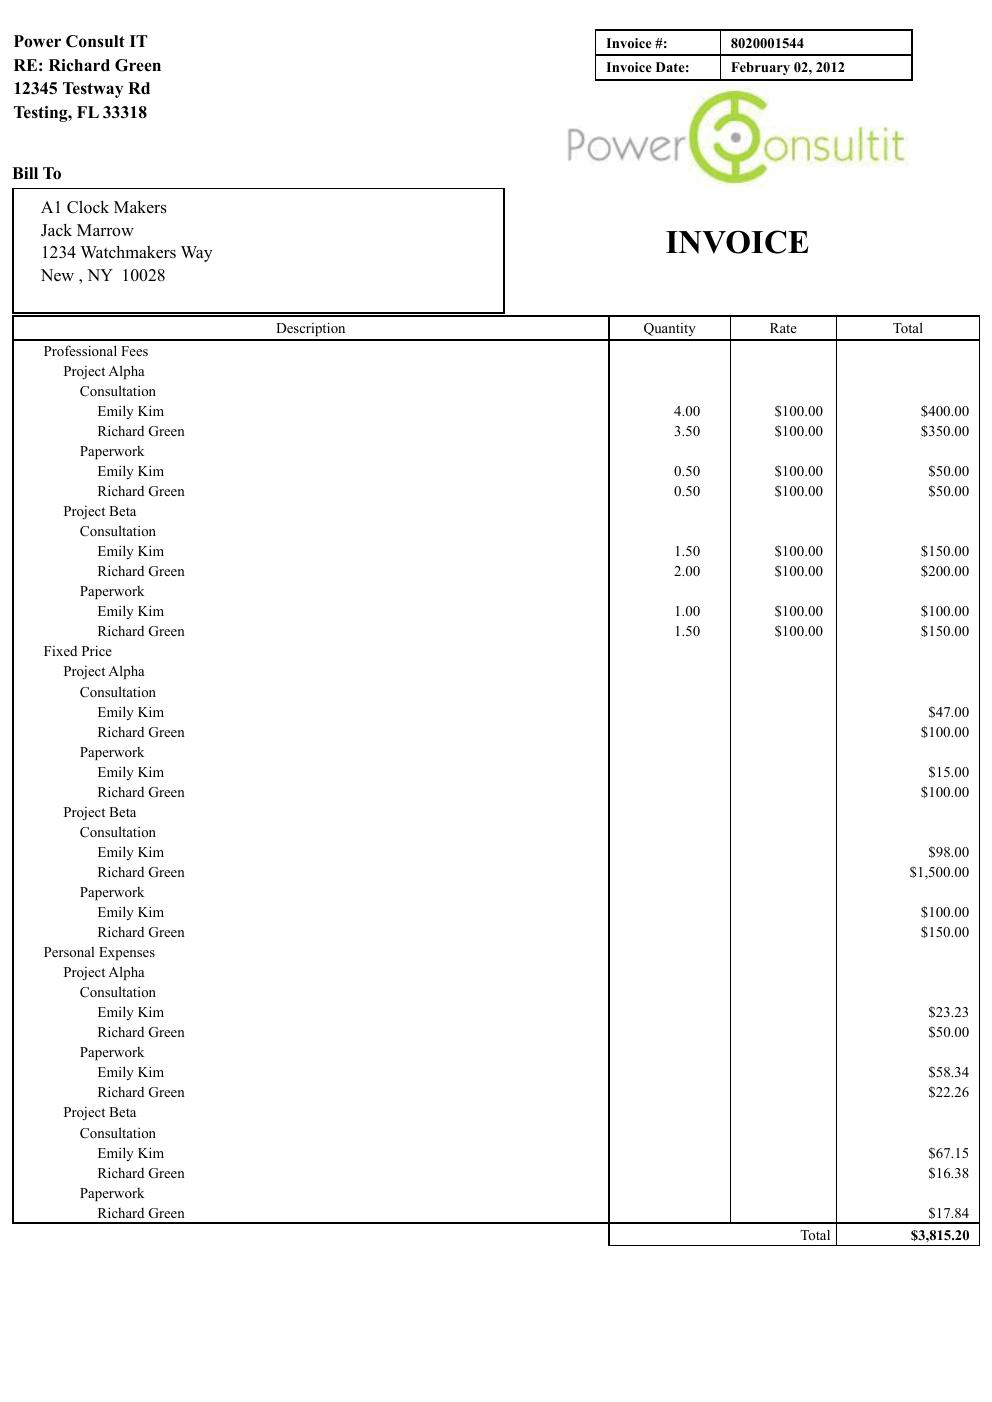

In [138]:
testwidget.image

In [74]:
submit()

Submit start


KeyError: 'value'

In [38]:
files_path

'E://Aviv//ocr_project//archive (2)//InvoiceData//InvoiceDataPDF//'

In [22]:
files_path = 'E://Aviv//ocr_project//archive (2)//InvoiceData//InvoiceDataPDF//'

In [109]:
bb = anno.ocr('temp.jpg')
for ind,b in enumerate(bb):
    print(ind,b)

0 Power
1 Consult
2 IT
3 RE:
4 Richard
5 Green
6 12345
7 Testway
8 Rd
9 Testing,
10 FL
11 33318
12 Bill
13 To
14 8020001544
15 Invoice
16 Date:
17 February
18 02,
19 2012
20 Al
21 Clock
22 Makers
23 Jack
24 Marrow
25 1234
26 Watchmakers
27 Way
28 New,
29 NY
30 10028
31 onsultit
32 INVOICE
33 Description
34 Quantity
35 Rate
36 Total
37 Professional
38 Fees
39 Project
40 Alpha
41 Consultation
42 Emily
43 Kim
44 4.00
45 $100.00
46 $400.00
47 Richard
48 Green
49 3.50
50 $100.00
51 $350.00
52 Paperwork
53 Emily
54 Kim
55 0.50
56 $100.00
57 $50.00
58 Richard
59 Green
60 050
61 $100.00
62 $50.00
63 Project
64 Beta
65 Consultation
66 Emily
67 Kim
68 1.50
69 $100.00
70 $150.00
71 Richard
72 Green
73 2.00
74 $100.00
75 $200.00
76 Paperwork
77 Emily
78 Kim
79 1.00
80 $100.00
81 $100.00
82 Richard
83 Green
84 1.50
85 $100.00
86 $150.00
87 Fixed
88 Price
89 Project
90 Alpha
91 Consultation
92 Emily
93 Kim
94 $47.00
95 Richard
96 Green
97 $100.00
98 Paperwork
99 Emily
100 Kim
101 $15.00
102 Richard


In [113]:
anno.check_valid('8020001544',value_type='text')

True

In [ ]:

    {
        "x": 725,
        "y": 28,
        "width": 90,
        "height": 24,
        "label": "r_number"
    }
